In [12]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.utils import np_utils

from pandas import read_csv
from sklearn.model_selection import train_test_split

In [65]:
dataset = read_csv("../datasets/mnist_data/train.csv").values
X_train, X_test, y_train, y_test = train_test_split(dataset[:,1:], dataset[:,0], 
                                                   test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [66]:
X_train, X_test = X_train/255, X_test/255
X_train, X_test = X_train.reshape((-1,28,28,1)), X_test.reshape((-1,28,28,1))

In [67]:
embedding_n = 256

inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3), padding='valid', activation='relu')(inp)
conv2 = Conv2D(16, (3,3), padding='valid', activation='relu')(conv1)
pool1 = MaxPool2D((2,2))(conv2)
conv3 = Conv2D(8, (3,3), padding='valid', activation='relu')(pool1)

fl1 = Flatten()(conv3)
em1 = Dense(embedding_n, activation='sigmoid')(fl1)
fc1 = Dense(800, activation='relu')(em1)
rs1 = Reshape((10,10,8))(fc1)

zp1 = ZeroPadding2D((1,1))(rs1)
dc1 = Conv2D(16, (3,3), padding='same', activation='relu')(zp1)
up1 = UpSampling2D((2,2))(dc1)
zp2 = ZeroPadding2D((1,1))(up1)
dc2 = Conv2D(32, (3,3), padding='same', activation='relu')(zp2)
zp3 = ZeroPadding2D((1,1))(dc2)
dc3 = Conv2D(1, (3,3), padding='same', activation='relu')(zp3)

cae = Model(inputs=inp, outputs=dc3)
cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten_10 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               205056    
__________

In [68]:
cae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [69]:
encoder = Model(inputs=inp, outputs=em1)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten_10 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               205056    
Total para

In [70]:
cae.layers

In [71]:
decoder_input = Input(shape=(embedding_n,))
dec_layer = cae.layers[7](decoder_input)
for i in range(8, len(cae.layers)):
    dec_layer = cae.layers[i](dec_layer)
decoder = Model(inputs=decoder_input, outputs=dec_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 800)               205600    
_________________________________________________________________
reshape_9 (Reshape)          (None, 10, 10, 8)         0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 16)        1168      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 24, 24, 16)        0         
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 26, 26, 16)        0         
__________

In [72]:
# Train CAE on Full DS on CPU!
hist = cae.fit(X_train, X_train, 
                shuffle=True,
                epochs=10,
                batch_size=1024,
                validation_data=(X_test, X_test))

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 127s 4ms/step - loss: 0.0661 - acc: 0.8006 - val_loss: 0.0523 - val_acc: 0.8009
Epoch 2/10
33600/33600 [==============================] - 128s 4ms/step - loss: 0.0350 - acc: 0.8043 - val_loss: 0.0243 - val_acc: 0.8102
Epoch 3/10
33600/33600 [==============================] - 125s 4ms/step - loss: 0.0198 - acc: 0.8111 - val_loss: 0.0161 - val_acc: 0.8122
Epoch 4/10
33600/33600 [==============================] - 125s 4ms/step - loss: 0.0145 - acc: 0.8129 - val_loss: 0.0127 - val_acc: 0.8133
Epoch 5/10
33600/33600 [==============================] - 122s 4ms/step - loss: 0.0120 - acc: 0.8137 - val_loss: 0.0109 - val_acc: 0.8135
Epoch 6/10
33600/33600 [==============================] - 121s 4ms/step - loss: 0.0102 - acc: 0.8141 - val_loss: 0.0097 - val_acc: 0.8141
Epoch 7/10
33600/33600 [==============================] - 121s 4ms/step - loss: 0.0091 - acc: 0.8143 - val_loss: 0.0086 - v

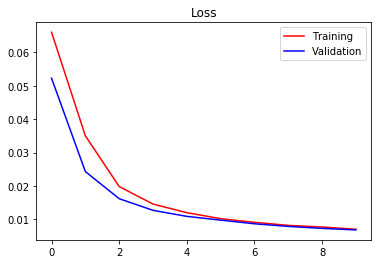

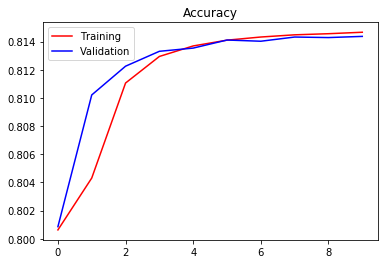

In [73]:
plt.figure(0)
plt.title("Loss")
plt.plot(hist.history['loss'], 'r', label='Training')
plt.plot(hist.history['val_loss'], 'b', label='Validation')
plt.legend()
plt.show()

plt.figure(1)
plt.title("Accuracy")
plt.plot(hist.history['acc'], 'r', label='Training')
plt.plot(hist.history['val_acc'], 'b', label='Validation')
plt.legend()
plt.show()

In [74]:
test = X_train[:20]
print(test.shape)
# encodings = encoder.predict(test)
# print(encodings.shape)
# decodings = decoder.predict(encodings)
# print(decodings.shape)
decodings = cae.predict(test)
decodings.shape

(20, 28, 28, 1)


(20, 28, 28, 1)

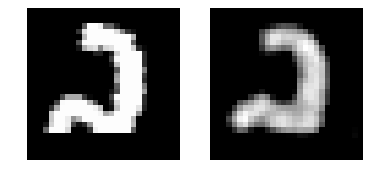

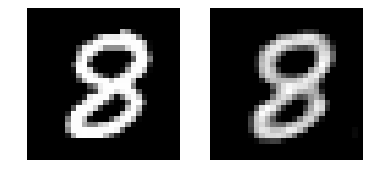

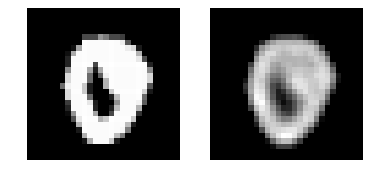

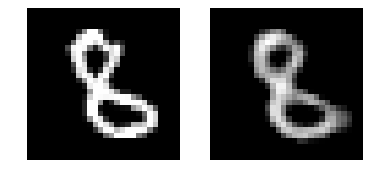

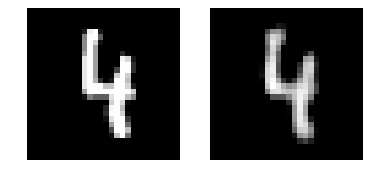

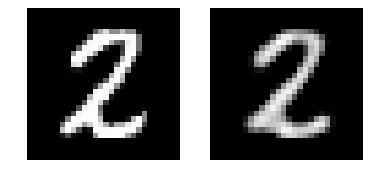

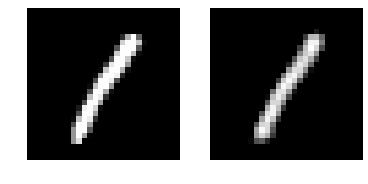

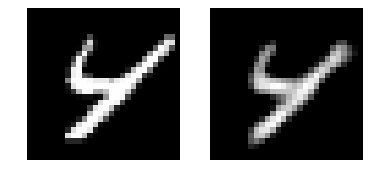

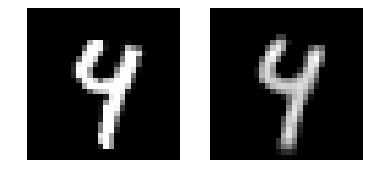

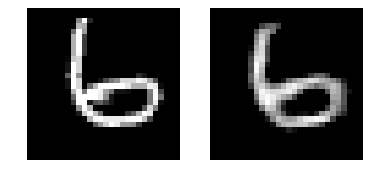

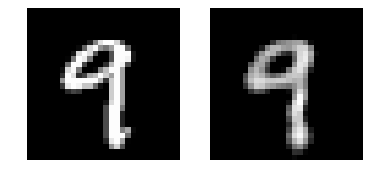

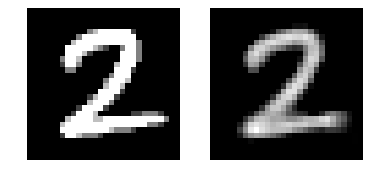

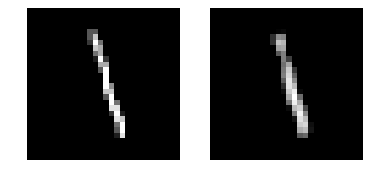

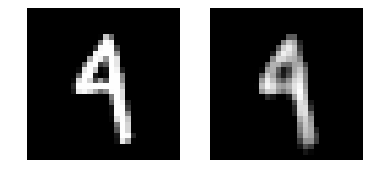

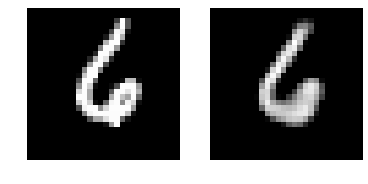

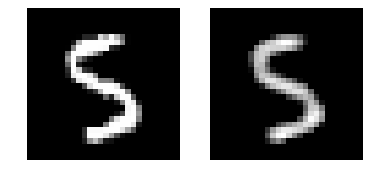

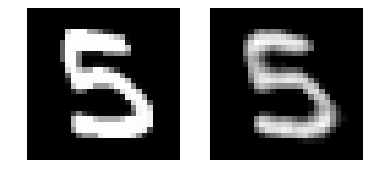

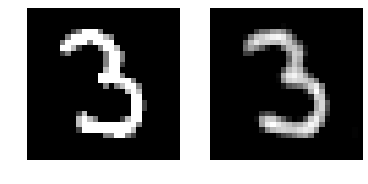

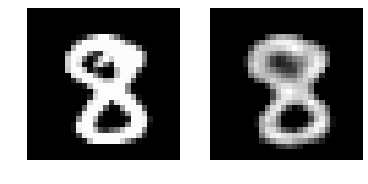

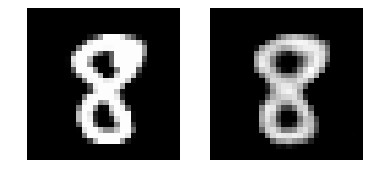

In [76]:
for i in range(test.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(test[i].reshape((28,28)), cmap='gray')
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(decodings[i].reshape((28,28)), cmap='gray')
    plt.axis("off")